In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import csv
from lib import *
%matplotlib inline

In [2]:
import os
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu,lib.cnmem=0.7,floatX=float32'

## Bundle model begins

In [3]:
folder = '../data/new_data'
bundle_item_map=pickle.load(open(folder + '/bundle_item_map.pkl','rb'))
bundle_price_map = pickle.load(open(folder + '/bundle_price_map', 'r'))
bundle_discount_map = pickle.load(open("../data/new_data/bundle_discount_map.pkl", "rb"))
bundle_price_arr = [bundle_price_map[i] for i in range(len(bundle_price_map)) if i]
bundle_discount_arr = [bundle_discount_map[i] for i in range(len(bundle_discount_map))]

In [4]:
folder = '../data/train_test'
bpr_item = pickle.load(open(folder +'/bpr_item.pkl','rb'))

In [5]:
H_item=bpr_item.H.eval()
B_item=bpr_item.B.eval()
W_item=bpr_item.W.eval()
TG_item=bpr_item.TG.eval()

In [6]:
folder = '../data/train_test'
sgd_users = pickle.load(open(folder +  "/sgd_users.pkl", "rb" ))
sgd_pos_items = pickle.load(open(folder +  "/sgd_pos_items.pkl", "rb" ))
sgd_neg_items = pickle.load(open(folder +  "/sgd_neg_items.pkl", "rb" ))
sgd_pos_bundles = pickle.load(open(folder +  "/sgd_pos_bundles.pkl", "rb" ))
sgd_neg_bundles = pickle.load(open(folder +  "/sgd_neg_bundles.pkl", "rb" ))
sgd_pos_len = pickle.load(open(folder +  "/sgd_pos_len.pkl", "rb" ))
sgd_neg_len = pickle.load(open(folder +  "/sgd_neg_len.pkl", "rb" ))
sgd_pos_diversity = pickle.load(open(folder +  "/sgd_pos_diversity.pkl", "rb" ))
sgd_neg_diversity = pickle.load(open(folder +  "/sgd_neg_diversity.pkl", "rb" ))

In [7]:
test_users = pickle.load(open(folder +  "/test_users.pkl", "rb" ))
test_pos_items = pickle.load(open(folder +  "/test_pos_items.pkl", "rb" ))
test_neg_items = pickle.load(open(folder +  "/test_neg_items.pkl", "rb" ))
test_pos_bundles = pickle.load(open(folder +  "/test_pos_bundles.pkl", "rb" ))
test_neg_bundles = pickle.load(open(folder +  "/test_neg_bundles.pkl", "rb" ))
test_n1 = pickle.load(open(folder +  "/test_n1.pkl", "rb" ))
test_n2 = pickle.load(open(folder +  "/test_n2.pkl", "rb" ))
test_pos_diversity = pickle.load(open(folder +  "/test_pos_diversity.pkl", "rb" ))
test_neg_diversity =pickle.load(open(folder +  "/test_neg_diversity.pkl", "rb" ))

In [8]:
sgd_pos_discount_percent = [bundle_discount_map[x] for x in sgd_pos_bundles]
sgd_neg_discount_percent = [bundle_discount_map[x] for x in sgd_neg_bundles]

In [9]:
test_pos_discount_percent = [bundle_discount_map[x] for x in test_pos_bundles]
test_neg_discount_percent = [bundle_discount_map[x] for x in test_neg_bundles]

In [8]:
# item_id_lookup =  pickle.load(open("../data/new_data/item_id_lookup.pkl", "rb"))
# user_item_map =  pickle.load(open("../data/new_data/user_item_map.pkl", "rb"))
# tag_array = pickle.load(open("../data/new_data/tag_array", "rb"))
# bundle_discount_map = pickle.load(open("../data/new_data/bundle_discount_map.pkl", "rb"))
# bundle_item_map = pickle.load(open("../data/new_data/bundle_item_map.pkl", "rb"))

In [9]:
# max_bundle_size = np.max([len(bundle_item_map[key]) for key in bundle_item_map])
# num_items = len(item_id_lookup)
# num_users = len(user_item_map)
# num_tags = len(tag_array.T)

In [10]:
# folder = '../data/train_test'
# pickle.dump(num_items, open(folder +  "/num_items", "wb" ))
# pickle.dump(max_bundle_size, open(folder +  "/max_bundle_size", "wb" ))
# pickle.dump(num_users, open(folder +  "/num_users", "wb" ))
# pickle.dump(num_tags, open(folder +  "/num_tags", "wb" ))

In [10]:
num_items = pickle.load(open(folder +  "/num_items", "r" ))
max_bundle_size = pickle.load(open(folder +  "/max_bundle_size", "r" ))
num_users = pickle.load(open(folder +  "/num_users", "r" ))
num_tags = 327

In [11]:
H_item = np.concatenate((H_item,np.zeros((1,np.shape(H_item)[1]))),axis=0)
H_item=np.array(H_item).astype('float32')
print np.shape(H_item)


B_item = np.append(B_item,0)
B_item=np.array(B_item).astype('float32')
print np.shape(B_item)

A_item = np.concatenate((TG_item,np.zeros((1,np.shape(TG_item)[1]))),axis=0)
A_item=np.array(A_item).astype('float32')
print np.shape(A_item)

(2516, 10)
(2516,)
(2516, 327)


In [12]:
TG_item = np.concatenate((TG_item,np.zeros((1,np.shape(TG_item)[1]))),axis=0)
TG_item=np.array(TG_item).astype('float32')
print np.shape(TG_item)

(2516, 327)


#  bundle non linear discount model

In [58]:
class BPR_Buncle5(object):
    def __init__(self, rank, bundle_size, n_users, n_items, n_tags, lambda_u = 0.0025, lambda_i = 0.0025, lambda_j = 0.00025, lambda_d = 0.0025, lambda_p = 0.00025, lambda_A = 0.01, lambda_bias = 0.0, learning_rate = 0.05):
        
        self._rank = rank
        self._bundle_rank = bundle_size + 1
        self._n_users = n_users
        self._n_items = n_items
        self._n_bundle = len(bundle_discount_map)
        self._lambda_u = lambda_u
        self._lambda_i = lambda_i
        self._lambda_j = lambda_j
        self._lambda_d = lambda_d
        self._lambda_p = lambda_p
        self._lambda_bias = lambda_bias
        self._lambda_A = lambda_A
        self._learning_rate = learning_rate
        
        self._n_tags = n_tags
        self._configure_theano()
        self._generate_train_model_item_function()
        self._generate_test_model_function()

    def _configure_theano(self):
        theano.config.mode = 'FAST_RUN'
        theano.config.floatX = 'float32'
    
    def _generate_train_model_item_function(self):
        u = T.lvector('u')
        i = T.lmatrix('i')
        j = T.lmatrix('j')
        n1 = T.lvector('n1')#num of items in pos bundle
        n2 = T.lvector('n2')
        di = T.dvector('di')#cb
        dj = T.dvector('dj')#cb
        bi = T.dvector('bi')
        bj = T.dvector('bj')
        
        self.W1 = bpr_item.W #Pu
        self.H1 = theano.shared(H_item.astype('float32'), name='H')#Qi
        self.B1 = theano.shared(B_item.astype('float32'), name='B')#Bi
        self.TG1 = theano.shared(A_item.astype('float32'), name='TG')
        self.theta1 = bpr_item.theta
        
        self.M1 = theano.shared(numpy.random.random((self._rank, self._rank)).astype('float64'), name='M1')#w
        self.M2 = theano.shared(numpy.random.random((self._rank, self._rank)).astype('float64'), name='M2')#u
        self.BDu = theano.shared(numpy.random.rand(), name='bdu')#discount
        self.K = theano.shared(numpy.random.rand(), name='K')#k
        self.D = theano.shared(numpy.random.rand(), name='D')#C
        self.N = theano.shared(numpy.random.random(self._bundle_rank).astype('float32'), name='N')#Nb
        self.A1 = theano.shared(numpy.random.random((self._n_tags, self._n_tags)), name='A1')
        self.A2 = theano.shared(numpy.random.random((self._n_tags, self._n_tags)), name='A2')
                                 
        pi = theano.tensor.constant(np.pi).eval()
        y_ui =  bi * pi - 0.5 * pi
        y_uj =  bj * pi - 0.5 * pi
        x_ui = T.dot(T.dot(self.W1[u],self.M2), T.dot(self.M1, self.H1[i].sum(axis=1).T/n1)).diagonal() + self.K*(self.B1[i].T/n1).T.sum(axis=1) + self.N[n1] + self.D*di + T.dot(T.dot(self.theta1[u],self.A1), T.dot(self.A2, self.TG1[i].sum(axis=1).T/n1)).diagonal()\
                + self.BDu * T.nnet.sigmoid(theano.tensor.tan(y_ui))
        x_uj = T.dot(T.dot(self.W1[u],self.M2), T.dot(self.M1, self.H1[j].sum(axis=1).T/n2)).diagonal() + self.K*(self.B1[j].T/n2).T.sum(axis=1) + self.N[n2] + self.D*dj + T.dot(T.dot(self.theta1[u],self.A1), T.dot(self.A2, self.TG1[j].sum(axis=1).T/n1)).diagonal()\
                + self.BDu * T.nnet.sigmoid(theano.tensor.tan(y_uj))
        
        x_uij = T.nnet.sigmoid(x_ui-x_uj)
        obj = T.sum(T.log(x_uij) - self._lambda_u * (self.M1 ** 2).sum() - \
                    self._lambda_u * (self.M2 ** 2).sum()  - self._lambda_d * (self.K**2) - self._lambda_d * (self.D**2)\
                    -self._lambda_p * (self.N[n2]**2) - self._lambda_p * (self.N[n1]**2)) - self._lambda_A * (self.A1 ** 2).sum() - self._lambda_A * (self.A2 ** 2).sum()\
                    - 0.001 * (self.BDu ** 2)
        cost = - obj

        g_cost_M1 = T.grad(cost=cost, wrt=self.M1)
        g_cost_M2 = T.grad(cost=cost, wrt=self.M2)
        g_cost_K = T.grad(cost=cost, wrt=self.K)
        g_cost_N = T.grad(cost=cost, wrt=self.N)
        g_cost_D = T.grad(cost=cost, wrt=self.D)
        g_cost_A1 = T.grad(cost=cost, wrt=self.A1)
        g_cost_A2 = T.grad(cost=cost, wrt=self.A2)
        g_cost_BDu = T.grad(cost=cost, wrt=self.BDu)
        
        updates = [(self.M1, self.M1 - self._learning_rate * .001* g_cost_M1), (self.M2, self.M2 - self._learning_rate *.001* g_cost_M2), 
                   (self.K, self.K - self._learning_rate * .001*g_cost_K), (self.N, self.N - self._learning_rate *g_cost_N),
                  (self.D, self.D - self._learning_rate * g_cost_D), 
                   (self.A1, self.A1-self._learning_rate * .001 * g_cost_A1), (self.A2, self.A2-self._learning_rate * .001 * g_cost_A2),
                  (self.BDu, self.BDu-self._learning_rate * .001 * g_cost_BDu)]

        self.train_model_item = theano.function(inputs=[u, i, j, n1, n2, di, dj, bi, bj], outputs=cost, updates=updates)

    
    def train(self, s_users=None, s_pos_items=None, s_neg_items=None, s_pos_len=None, s_neg_len=None,
             s_pos_diversity=None, s_neg_diversity=None, bd_pos_discount = None, bd_neg_discount = None, batch_size=1000):
        
        if len(s_users) < batch_size:
            sys.stderr.write("WARNING: Batch size is greater than number of training samples, switching to a batch size of %s\n" % str(len(train_data)))
            batch_size = len(s_users)
        
        sgd_users, sgd_pos_items, sgd_neg_items = s_users, s_pos_items, s_neg_items
        n_sgd_samples = len(s_users)

        z = 0
        t2 = t1 = t0 = time.time()
        while (z+1)*batch_size < n_sgd_samples:
            
            self.train_model_item(
                sgd_users[z*batch_size: (z+1)*batch_size],
                sgd_pos_items[z*batch_size: (z+1)*batch_size],
                sgd_neg_items[z*batch_size: (z+1)*batch_size],
                s_pos_len[z*batch_size: (z+1)*batch_size],
                s_neg_len[z*batch_size: (z+1)*batch_size],
                s_pos_diversity[z*batch_size: (z+1)*batch_size],
                s_neg_diversity[z*batch_size: (z+1)*batch_size],
                bd_pos_discount[z*batch_size: (z+1)*batch_size],
                bd_neg_discount[z*batch_size: (z+1)*batch_size]
            )
            z += 1
            t2 = time.time()
            sys.stderr.write("\rProcessed %s ( %.2f%% ) in %.4f seconds" %(str(z*batch_size), 100.0 * float(z*batch_size)/n_sgd_samples, t2 - t1))
            sys.stderr.flush()
            t1 = t2
        if n_sgd_samples > 0:
            sys.stderr.write("\nTotal training time %.2f seconds; %e per sample\n" % (t2 - t0, (t2 - t0)/n_sgd_samples))
            sys.stderr.flush()
    
    def _generate_test_model_function(self):
        u = T.lvector('u')
        i = T.lmatrix('i')
        j = T.lmatrix('j')
        n1 = T.lvector('n1')
        n2 = T.lvector('n2')
        di = T.dvector('di')
        dj = T.dvector('dj')
        bi = T.dvector('bi')
        bj = T.dvector('bj')
        
        pi = theano.tensor.constant(np.pi).eval()
        y_ui =  bi * pi - 0.5 * pi
        y_uj =  bj * pi - 0.5 * pi
        x_ui = T.dot(T.dot(self.W1[u],self.M2), T.dot(self.M1, self.H1[i].sum(axis=1).T/n1)).diagonal() + self.K*(self.B1[i].T/n1).T.sum(axis=1) + self.N[n1] + self.D*di + T.dot(T.dot(self.theta1[u],self.A1), T.dot(self.A2, self.TG1[i].sum(axis=1).T/n1)).diagonal()\
                + self.BDu * T.nnet.sigmoid(theano.tensor.tan(y_ui))
        x_uj = T.dot(T.dot(self.W1[u],self.M2), T.dot(self.M1, self.H1[j].sum(axis=1).T/n2)).diagonal() + self.K*(self.B1[j].T/n2).T.sum(axis=1) + self.N[n2] + self.D*dj + T.dot(T.dot(self.theta1[u],self.A1), T.dot(self.A2, self.TG1[j].sum(axis=1).T/n1)).diagonal()\
                + self.BDu * T.nnet.sigmoid(theano.tensor.tan(y_uj))
            
        x_uij = x_ui-x_uj
        self.test_model = theano.function(inputs=[u, i, j, n1, n2, di, dj, bi, bj], outputs= x_uij)
        
    def test_bundle(self, sgd_users, sgd_pos_items, sgd_neg_items, s_pos_len, s_neg_len,
                    s_pos_diversity, s_neg_diversity, bd_pos_discount, bd_neg_discount, batch_size=1000):
        
        auc_values = []
        z = 0
        t2 = t1 = t0 = time.time()
        n_sgd_samples = len(sgd_users)
        while (z+1)*batch_size < n_sgd_samples:
            pref_list =self.test_model(
                sgd_users[z*batch_size: (z+1)*batch_size],
                sgd_pos_items[z*batch_size: (z+1)*batch_size],
                sgd_neg_items[z*batch_size: (z+1)*batch_size],
                s_pos_len[z*batch_size: (z+1)*batch_size],
                s_neg_len[z*batch_size: (z+1)*batch_size],
                s_pos_diversity[z*batch_size: (z+1)*batch_size],
                s_neg_diversity[z*batch_size: (z+1)*batch_size],
                bd_pos_discount[z*batch_size: (z+1)*batch_size],
                bd_neg_discount[z*batch_size: (z+1)*batch_size]
            )
            z += 1
            t2 = time.time()
            sys.stderr.write("\rProcessed %s ( %.2f%% ) in %.4f seconds" %(str(z*batch_size), 100.0 * float(z*batch_size)/n_sgd_samples, t2 - t1))
            t1 = t2
            
            sys.stderr.write("pref%d" % len(pref_list))
            sys.stderr.flush()
            auc = np.sum([1.0 if a > 0.0 else 0.0 for a in pref_list])
            auc /= batch_size
            
            auc_values.append(auc)
            sys.stderr.write("\rCurrent AUC mean (%s samples): %0.5f" % (str(z*batch_size), numpy.mean(auc_values)))
            sys.stderr.flush()
        sys.stderr.write("\n")
        sys.stderr.flush()
        return numpy.mean(auc_values)
        #return [x_uis, x_ujs, y_uis, y_ujs]

In [59]:
print max_bundle_size, num_users, num_items, num_tags

82 29633 2515 327


In [60]:
bpr_bundle5 = BPR_Buncle5(10, max_bundle_size, num_users, num_items, \
                        num_tags)

In [61]:
bpr_bundle5.train(s_users=sgd_users, s_pos_items=sgd_pos_items, s_neg_items=sgd_neg_items, 
            s_pos_len=sgd_pos_len, s_neg_len=sgd_neg_len, s_pos_diversity=sgd_pos_diversity,
            s_neg_diversity=sgd_neg_diversity, \
                bd_pos_discount = sgd_pos_discount_percent, bd_neg_discount = sgd_neg_discount_percent)

Processed 2101000 ( 99.99% ) in 0.3313 seconds
Total training time 734.91 seconds; 3.497679e-04 per sample


In [34]:
res5 = bpr_bundle5.test_bundle(test_users, test_pos_items, test_neg_items, test_n1, test_n2,\
                       test_pos_diversity, test_neg_diversity,\
                      test_pos_bundles, test_neg_bundles)

Current AUC mean (420000 samples): 0.93915ndspref1000


# recover bundle non linear discount model

In [13]:
class BPR_Buncle6(object):
    def __init__(self, rank, bundle_size, n_users, n_items, n_tags, bundle_discount_arr, bundle_price_arr, lambda_u = 0.0025, lambda_i = 0.0025, lambda_j = 0.00025, lambda_d = 0.0025, lambda_p = 0.00025, lambda_A = 0.01, lambda_bias = 0.0, learning_rate = 0.05):
        
        self._rank = rank
        self._bundle_rank = bundle_size + 1
        self._n_users = n_users
        self._n_items = n_items
        self._n_bundle = len(bundle_discount_map)
        self.bundle_discount_arr = theano.shared(np.array(bundle_discount_arr))
        self.bundle_price_arr = theano.shared(np.array(bundle_price_arr))
        self._lambda_u = lambda_u
        self._lambda_i = lambda_i
        self._lambda_j = lambda_j
        self._lambda_d = lambda_d
        self._lambda_p = lambda_p
        self._lambda_bias = lambda_bias
        self._lambda_A = lambda_A
        self._learning_rate = learning_rate
        
        self._n_tags = n_tags
        self._configure_theano()
        self._generate_train_model_item_function()
        self._generate_test_model_function()

    def _configure_theano(self):
        theano.config.mode = 'FAST_RUN'
        theano.config.floatX = 'float32'
    
    def _generate_train_model_item_function(self):
        u = T.lvector('u')
        i = T.lmatrix('i')
        j = T.lmatrix('j')
        n1 = T.lvector('n1')#num of items in pos bundle
        n2 = T.lvector('n2')
        di = T.dvector('di')#cb
        dj = T.dvector('dj')#cb
        bi = T.lvector('bi')
        bj = T.lvector('bj')
        
        self.W1 = bpr_item.W #Pu
        self.H1 = theano.shared(H_item.astype('float32'), name='H')#Qi
        self.B1 = theano.shared(B_item.astype('float32'), name='B')#Bi
        self.TG1 = theano.shared(A_item.astype('float32'), name='TG')
        self.theta1 = bpr_item.theta
        
        self.M1 = theano.shared(numpy.random.random((self._rank, self._rank)).astype('float64'), name='M1')#w
        self.M2 = theano.shared(numpy.random.random((self._rank, self._rank)).astype('float64'), name='M2')#u
        self.BDu = theano.shared(numpy.random.rand(), name='bdu')#discount
        self.K = theano.shared(numpy.random.rand(), name='K')#k
        self.D = theano.shared(numpy.random.rand(), name='D')#C
        self.N = theano.shared(numpy.random.random(self._bundle_rank).astype('float32'), name='N')#Nb
        self.A1 = theano.shared(numpy.random.random((self._n_tags, self._n_tags)), name='A1')
        self.A2 = theano.shared(numpy.random.random((self._n_tags, self._n_tags)), name='A2')
                                
        discount_price_i =  self.bundle_price_arr[bi] / (1 - self.bundle_discount_arr[bi]) * self.bundle_discount_arr[bi]
        discount_price_j =  self.bundle_price_arr[bj] / (1 - self.bundle_discount_arr[bj]) * self.bundle_discount_arr[bj]
        
        pi = theano.tensor.constant(np.pi).eval()
        y_ui =  self.bundle_discount_arr[bi] * pi - 0.5 * pi
        y_uj =  self.bundle_discount_arr[bj] * pi - 0.5 * pi
        x_ui = T.dot(T.dot(self.W1[u],self.M2), T.dot(self.M1, self.H1[i].sum(axis=1).T/n1)).diagonal() + self.K*(self.B1[i].T/n1).T.sum(axis=1) + self.N[n1] + self.D*di + T.dot(T.dot(self.theta1[u],self.A1), T.dot(self.A2, self.TG1[i].sum(axis=1).T/n1)).diagonal()\
                + self.BDu * T.nnet.sigmoid(theano.tensor.tan(y_ui))
        x_uj = T.dot(T.dot(self.W1[u],self.M2), T.dot(self.M1, self.H1[j].sum(axis=1).T/n2)).diagonal() + self.K*(self.B1[j].T/n2).T.sum(axis=1) + self.N[n2] + self.D*dj + T.dot(T.dot(self.theta1[u],self.A1), T.dot(self.A2, self.TG1[j].sum(axis=1).T/n1)).diagonal()\
                + self.BDu * T.nnet.sigmoid(theano.tensor.tan(y_uj))
        
        
        x_uij = T.nnet.sigmoid(x_ui-x_uj)
        obj = T.sum(T.log(x_uij) - self._lambda_u * (self.M1 ** 2).sum() - \
                    self._lambda_u * (self.M2 ** 2).sum()  - self._lambda_d * (self.K**2) - self._lambda_d * (self.D**2)\
                    -self._lambda_p * (self.N[n2]**2) - self._lambda_p * (self.N[n1]**2)) - self._lambda_A * (self.A1 ** 2).sum() - self._lambda_A * (self.A2 ** 2).sum()\
                    - 0.001 * (self.BDu ** 2)
        cost = - obj

        g_cost_M1 = T.grad(cost=cost, wrt=self.M1)
        g_cost_M2 = T.grad(cost=cost, wrt=self.M2)
        g_cost_K = T.grad(cost=cost, wrt=self.K)
        g_cost_N = T.grad(cost=cost, wrt=self.N)
        g_cost_D = T.grad(cost=cost, wrt=self.D)
        g_cost_A1 = T.grad(cost=cost, wrt=self.A1)
        g_cost_A2 = T.grad(cost=cost, wrt=self.A2)
        g_cost_BDu = T.grad(cost=cost, wrt=self.BDu)
        
        updates = [(self.M1, self.M1 - self._learning_rate * .001* g_cost_M1), (self.M2, self.M2 - self._learning_rate *.001* g_cost_M2), 
                   (self.K, self.K - self._learning_rate * .001*g_cost_K), (self.N, self.N - self._learning_rate *g_cost_N),
                  (self.D, self.D - self._learning_rate * g_cost_D), 
                   (self.A1, self.A1-self._learning_rate * .001 * g_cost_A1), (self.A2, self.A2-self._learning_rate * .001 * g_cost_A2),
                  (self.BDu, self.BDu-self._learning_rate * .001 * g_cost_BDu)]

        self.train_model_item = theano.function(inputs=[u, i, j, n1, n2, di, dj, bi, bj], outputs=cost, updates=updates)

    
    def train(self, s_users=None, s_pos_items=None, s_neg_items=None, s_pos_len=None, s_neg_len=None,
             s_pos_diversity=None, s_neg_diversity=None, bd_pos_bundle = None, bd_neg_bundle = None, batch_size=1000):
        
        if len(s_users) < batch_size:
            sys.stderr.write("WARNING: Batch size is greater than number of training samples, switching to a batch size of %s\n" % str(len(train_data)))
            batch_size = len(s_users)
        
        sgd_users, sgd_pos_items, sgd_neg_items = s_users, s_pos_items, s_neg_items
        n_sgd_samples = len(s_users)

        z = 0
        t2 = t1 = t0 = time.time()
        while (z+1)*batch_size < n_sgd_samples:
            
            self.train_model_item(
                sgd_users[z*batch_size: (z+1)*batch_size],
                sgd_pos_items[z*batch_size: (z+1)*batch_size],
                sgd_neg_items[z*batch_size: (z+1)*batch_size],
                s_pos_len[z*batch_size: (z+1)*batch_size],
                s_neg_len[z*batch_size: (z+1)*batch_size],
                s_pos_diversity[z*batch_size: (z+1)*batch_size],
                s_neg_diversity[z*batch_size: (z+1)*batch_size],
                bd_pos_bundle[z*batch_size: (z+1)*batch_size],
                bd_neg_bundle[z*batch_size: (z+1)*batch_size]
            )
            z += 1
            t2 = time.time()
            sys.stderr.write("\rProcessed %s ( %.2f%% ) in %.4f seconds" %(str(z*batch_size), 100.0 * float(z*batch_size)/n_sgd_samples, t2 - t1))
            sys.stderr.flush()
            t1 = t2
        if n_sgd_samples > 0:
            sys.stderr.write("\nTotal training time %.2f seconds; %e per sample\n" % (t2 - t0, (t2 - t0)/n_sgd_samples))
            sys.stderr.flush()
    
    def _generate_test_model_function(self):
        u = T.lvector('u')
        i = T.lmatrix('i')
        j = T.lmatrix('j')
        n1 = T.lvector('n1')
        n2 = T.lvector('n2')
        di = T.dvector('di')
        dj = T.dvector('dj')
        
        x_ui = T.dot(T.dot(self.W1[u],self.M2), T.dot(self.M1, self.H1[i].sum(axis=1).T/n1)).diagonal() + self.K*(self.B1[i].T/n1).T.sum(axis=1) + self.N[n1] + self.D*di + T.dot(T.dot(self.theta1[u],self.A1), T.dot(self.A2, self.TG1[i].sum(axis=1).T/n1)).diagonal()
        x_uj = T.dot(T.dot(self.W1[u],self.M2), T.dot(self.M1, self.H1[j].sum(axis=1).T/n2)).diagonal() + self.K*(self.B1[j].T/n2).T.sum(axis=1) + self.N[n2] + self.D*dj + T.dot(T.dot(self.theta1[u],self.A1), T.dot(self.A2, self.TG1[j].sum(axis=1).T/n1)).diagonal()
        
        x_uij = x_ui-x_uj
        self.test_model = theano.function(inputs=[u, i, j, n1, n2, di, dj], outputs=x_uij)
        
    def test_bundle(self, sgd_users, sgd_pos_items, sgd_neg_items, s_pos_len, s_neg_len,
                    s_pos_diversity, s_neg_diversity, batch_size=1000):
        
        auc_values = []
        z = 0
        t2 = t1 = t0 = time.time()
        n_sgd_samples = len(sgd_users)
        while (z+1)*batch_size < n_sgd_samples:
            pref_list=self.test_model(
                sgd_users[z*batch_size: (z+1)*batch_size],
                sgd_pos_items[z*batch_size: (z+1)*batch_size],
                sgd_neg_items[z*batch_size: (z+1)*batch_size],
                s_pos_len[z*batch_size: (z+1)*batch_size],
                s_neg_len[z*batch_size: (z+1)*batch_size],
                s_pos_diversity[z*batch_size: (z+1)*batch_size],
                s_neg_diversity[z*batch_size: (z+1)*batch_size]
            )
            z += 1
            t2 = time.time()
            sys.stderr.write("\rProcessed %s ( %.2f%% ) in %.4f seconds" %(str(z*batch_size), 100.0 * float(z*batch_size)/n_sgd_samples, t2 - t1))
            t1 = t2
            
            sys.stderr.write("pref%d" % len(pref_list))
            sys.stderr.flush()
            auc = np.sum([1.0 if a > 0.0 else 0.0 for a in pref_list])
            auc /= batch_size
            
            auc_values.append(auc)
            sys.stderr.write("\rCurrent AUC mean (%s samples): %0.5f" % (str(z*batch_size), numpy.mean(auc_values)))
            sys.stderr.flush()
        sys.stderr.write("\n")
        sys.stderr.flush()
        return numpy.mean(auc_values)

In [14]:
bpr_bundle6 = BPR_Buncle6(10, max_bundle_size, num_users, num_items, \
                        num_tags, bundle_discount_arr, bundle_price_arr)

In [15]:
bpr_bundle6.train(s_users=sgd_users, s_pos_items=sgd_pos_items, s_neg_items=sgd_neg_items, 
            s_pos_len=sgd_pos_len, s_neg_len=sgd_neg_len, s_pos_diversity=sgd_pos_diversity,
            s_neg_diversity=sgd_neg_diversity, \
                bd_pos_bundle = sgd_pos_bundles, bd_neg_bundle = sgd_neg_bundles)

Processed 2101000 ( 99.99% ) in 0.3196 seconds
Total training time 729.36 seconds; 3.471246e-04 per sample


In [16]:
bpr_bundle6.test_bundle(test_users, test_pos_items, test_neg_items, test_n1, test_n2,\
                       test_pos_diversity, test_neg_diversity)

Current AUC mean (420000 samples): 0.93552ndspref1000ef1000pref1000pref1000pref1000pref1000pref1000pref1000pref1000pref1000


0.93551904761904758

# generate_bundle

In [17]:
folder = '../data/new_data'
user_item_map = pickle.load(open(folder + '/user_item_map.pkl','rb'))
user_bundle_map = pickle.load(open(folder + '/user_bundle_map.pkl','rb'))
items_set = set(pickle.load(open(folder + '/item_id_lookup.pkl','rb')).keys())

In [18]:
item_pick_prob_arr = pickle.load(open('../data/new_data/item_pick_prob_arr.pkl', 'rb'))
bundle_diversity_map = pickle.load(open('../data/new_data/bundle_diversity_map','rb'))

In [19]:
unbuy_items = pickle.load(open('../data/new_data/unbuy_items.pkl','rb'))

In [20]:
bpr_cold = bpr_bundle6
Gamma = H_item

# old bundle generating

In [21]:
def generate_bundle0(items_set, user, initial_size = 3, max_iteration = 1000, sample_size = 5):
    current_bundle = np.random.choice(list(items_set), initial_size)
    
    T=1000.0
    
    iteration = 0
    while iteration < max_iteration:
        iteration+=1
        curr_diversity = compute_diversity(current_bundle, Gamma)
        user_set=[]
        pos_item_set=[]
        actual_item_set=[]
        neg_item_set=[]
        pos_item_count=[]
        neg_item_count=[]
        pos_diversity=[]
        neg_diversity=[]
        
        
        candidate_items = set(np.random.choice(list(items_set), sample_size))
        
        for item in current_bundle:
            if item in candidate_items:
                candidate_items.remove(item)
        
    
        #Generating new bundles by adding and removing new items  
        for cand_item in candidate_items:
            #Add an item case
            if len(current_bundle)<10:
                user_set.append(user)    
                neg_item_set.append(add_bogus_items(current_bundle , max_bundle_size, len(items_set)))
                neg_item_count.append(len(current_bundle))
                neg_diversity.append(curr_diversity)         
                new_bundle=list(current_bundle)
                new_bundle.append(cand_item)
                pos_item_count.append(len(new_bundle))
                pos_diversity.append(compute_diversity(new_bundle, Gamma))
                actual_item_set.append(new_bundle)
                pos_item_set.append(add_bogus_items(new_bundle , max_bundle_size, len(items_set)))

            # Replace an item case
            for curr_item in current_bundle:
                user_set.append(user)
                
                neg_item_set.append(add_bogus_items(current_bundle , max_bundle_size, len(items_set)))
                neg_item_count.append(len(current_bundle))
                neg_diversity.append(curr_diversity)
                
                new_bundle=list(current_bundle)
                new_bundle.append(cand_item)
                new_bundle.remove(curr_item)
                pos_item_set.append(add_bogus_items(new_bundle , max_bundle_size, len(items_set)))
                actual_item_set.append(new_bundle)
                pos_item_count.append(len(new_bundle))
                pos_diversity.append(compute_diversity(new_bundle, Gamma))
         
        
        # Remove an item case
        if len(current_bundle)>2:
            for curr_item in current_bundle:
                user_set.append(user)

                neg_item_set.append(add_bogus_items(current_bundle , max_bundle_size, len(items_set)))
                neg_item_count.append(len(current_bundle))
                neg_diversity.append(curr_diversity)

                new_bundle=list(current_bundle)
                new_bundle.remove(curr_item)
                actual_item_set.append(new_bundle)
                pos_item_set.append(add_bogus_items(new_bundle , max_bundle_size, len(items_set)))
                pos_item_count.append(len(new_bundle))
                pos_diversity.append(compute_diversity(new_bundle, Gamma))
        
                
        pref_score = bpr_cold.test_model(user_set, pos_item_set, neg_item_set, pos_item_count, 
                                    neg_item_count, pos_diversity, neg_diversity)
                                    
        #print pref_score, pos_item_count, neg_item_count
        index = np.argmax(pref_score)
        #print "Pref Score ", pref_score[index]
        if(pref_score[index]>0):
            current_bundle = actual_item_set[index]
        else:
            prob = np.exp(pref_score[index]/T)
            if prob < .00001:
                break
            if np.random.rand() < prob:
                current_bundle = actual_item_set[index]
        T=T*0.9
    #print iteration
    return current_bundle

# new bundle generating

In [91]:
def generate_bundle(items_set, user, user_item_map, initial_size = 3, max_iteration = 1000, sample_size = 5):
    
    item_pick_prob_arr_user = [item_pick_prob_arr[x] if x not in user_item_map[user] else 0 for x in range(len(item_pick_prob_arr))]
    total = np.sum(item_pick_prob_arr_user)
    item_pick_prob_arr_user = [float(x) / total for x in item_pick_prob_arr_user]
    current_bundle = np.random.choice(range(len(item_pick_prob_arr_user)), initial_size , 
                                     p = item_pick_prob_arr_user, replace = False)

    T=1000.0
    
    iteration = 0
    while iteration < max_iteration:
        iteration+=1
        Gamma = H_item
        curr_diversity = compute_diversity(current_bundle, Gamma)
        user_set=[]
        pos_item_set=[]
        actual_item_set=[]
        neg_item_set=[]
        pos_item_count=[]
        neg_item_count=[]
        pos_diversity=[]
        neg_diversity=[]
        pos_discount = []
        neg_discount = []
                
        if np.random.rand() < 0.5:
            candidate_items = set(np.random.choice(range(len(item_pick_prob_arr_user)), sample_size, 
                                              p = item_pick_prob_arr_user, replace = False))
        else:
            candidate_items = set(np.random.choice(list(unbuy_items), sample_size))
        
        for item in current_bundle:
            if item in candidate_items:
                candidate_items.remove(item)
        
        
    
        #Generating new bundles by adding and removing new items  
        for cand_item in candidate_items:
            #Add an item case
            if len(current_bundle)<10:
                user_set.append(user)    
                neg_item_set.append(add_bogus_items(current_bundle , max_bundle_size, len(items_set)))
                neg_item_count.append(len(current_bundle))
                neg_diversity.append(curr_diversity)         
                new_bundle=list(current_bundle)
                new_bundle.append(cand_item)
                pos_item_count.append(len(new_bundle))
                pos_diversity.append(compute_diversity(new_bundle, Gamma))
                actual_item_set.append(new_bundle)
                pos_item_set.append(add_bogus_items(new_bundle , max_bundle_size, len(items_set)))
                pos_discount.append(0)
                neg_discount.append(0)
                
            # Replace an item case
            for curr_item in current_bundle:
                user_set.append(user)
                
                neg_item_set.append(add_bogus_items(current_bundle , max_bundle_size, len(items_set)))
                neg_item_count.append(len(current_bundle))
                neg_diversity.append(curr_diversity)
                
                new_bundle=list(current_bundle)
                new_bundle.append(cand_item)
                new_bundle.remove(curr_item)
                pos_item_set.append(add_bogus_items(new_bundle , max_bundle_size, len(items_set)))
                actual_item_set.append(new_bundle)
                pos_item_count.append(len(new_bundle))
                pos_diversity.append(compute_diversity(new_bundle, Gamma))
                pos_discount.append(0)
                neg_discount.append(0)
         
        
        # Remove an item case
        if len(current_bundle)>2:
            for curr_item in current_bundle:
                user_set.append(user)

                neg_item_set.append(add_bogus_items(current_bundle , max_bundle_size, len(items_set)))
                neg_item_count.append(len(current_bundle))
                neg_diversity.append(curr_diversity)

                new_bundle=list(current_bundle)
                new_bundle.remove(curr_item)
                actual_item_set.append(new_bundle)
                pos_item_set.append(add_bogus_items(new_bundle , max_bundle_size, len(items_set)))
                pos_item_count.append(len(new_bundle))
                pos_diversity.append(compute_diversity(new_bundle, Gamma))
                pos_discount.append(0)
                neg_discount.append(0)
        
                
#         pref_score = bpr_cold.test_model(user_set, pos_item_set, neg_item_set, pos_item_count, 
#                                     neg_item_count, pos_diversity, neg_diversity,
#                                     pos_discount, neg_discount)
        pref_score = bpr_cold.test_model(user_set, pos_item_set, neg_item_set, pos_item_count, 
                                    neg_item_count, pos_diversity, neg_diversity)
                                    
        #print pref_score, pos_item_count, neg_item_count
        index = np.argmax(pref_score)
        #print "Pref Score ", pref_score[index]
        if(pref_score[index]>0):
            current_bundle = actual_item_set[index]
        else:
            prob = np.exp(pref_score[index]/T)
            if prob < .00001:
                break
            if np.random.rand() < prob:
                current_bundle = actual_item_set[index]
        T=T*0.9
#     print iteration
    return current_bundle

In [92]:
def add_bogus_items(bundle, max_bundle_size, index):
    item=list(bundle);
    for i in range(len(item),max_bundle_size):
        item.append(index)
    return item

def remove_bogus_items(bundle, max_bundle_size, index):
    item=list(bundle);
    i=0
    while i< len(bundle):
        if bundle[i]==index:
            break
        i+=1
    return bundle[:i]

def get_bundle_rank(user, new_bundle, bundle_item_map, bundle_diversity_map, Gamma):
    user_set=[]
    pos_item_set=[]
    neg_item_set=[]
    pos_item_count=[]
    neg_item_count=[]
    pos_diversity=[]
    neg_diversity=[]
    pos_discount = []
    neg_discount = []
    
    bundle_diversity=compute_diversity(new_bundle, Gamma)
    for bundle_id,bundle in bundle_item_map.items():
        user_set.append(user)
        pos_item_set.append(add_bogus_items(bundle, max_bundle_size, len(items_set)))
        neg_item_set.append(add_bogus_items(new_bundle, max_bundle_size, len(items_set)))
        pos_item_count.append(len(bundle))
        neg_item_count.append(len(new_bundle))
        pos_diversity.append(bundle_diversity_map[bundle_id])
        neg_diversity.append(bundle_diversity)
        pos_discount.append(0)
        neg_discount.append(0)
        
#     pref_score = bpr_cold.test_model(user_set, pos_item_set, neg_item_set, pos_item_count, 
#                                     neg_item_count, pos_diversity, neg_diversity, 
#                                     pos_discount, neg_discount)
    pref_score = bpr_cold.test_model(user_set, pos_item_set, neg_item_set, pos_item_count, 
                                    neg_item_count, pos_diversity, neg_diversity)
    rank = np.sum([1.0 if p>0 else 0.0 for p in pref_score])
    return rank

In [93]:
sizes=[10]
diversities=[]
scores=[]
bundle_sizes=[]
num_people = 100
for size in sizes:
    aggregate_diversity=set()
    pred_score=[]
    b_size=[]
    generated_bundles=[]
    k = 0
    for user in sorted(user_bundle_map.keys())[:num_people]:
        new_bundle = generate_bundle(items_set, user, user_item_map, 4, 1000,size)
        #new_bundle = generate_bundle0(items_set, user , 4, 1000,size)
        rank = get_bundle_rank(user, new_bundle, bundle_item_map, bundle_diversity_map, H_item)
        purchased_bundles = len(user_bundle_map[user])
        aggregate_diversity=aggregate_diversity.union(set(new_bundle))
        generated_bundles.append(new_bundle)
        pred_score.append(rank)
        b_size.append(len(new_bundle)*1.0)
        k += 1
        if k < 10:
            print 'Rank of user %d : %d, Size of bundle : %d, Bundles purchased : %d Aggregate diversity: %d Score: %f, Average bundle size: %f' %(user, 
                                                                                     rank, 
                                                                                     len(new_bundle),                                 
                                                                                     purchased_bundles,
                                                                                     len(aggregate_diversity),
                                                                                     1.0+np.mean(pred_score),
                                                                                     np.mean(b_size))
    diversities.append(len(aggregate_diversity))
    scores.append(1.0+np.mean(pred_score))
    bundle_sizes.append(np.mean(b_size)*num_people)
    print 'result......'
    print 'diversities', diversities, len(aggregate_diversity)
    print 'scores', scores
    print 'bundle_sizes', bundle_sizes

Rank of user 0 : 0, Size of bundle : 5, Bundles purchased : 6 Aggregate diversity: 5 Score: 1.000000, Average bundle size: 5.000000
Rank of user 1 : 0, Size of bundle : 5, Bundles purchased : 15 Aggregate diversity: 10 Score: 1.000000, Average bundle size: 5.000000
Rank of user 2 : 0, Size of bundle : 5, Bundles purchased : 1 Aggregate diversity: 15 Score: 1.000000, Average bundle size: 5.000000
Rank of user 3 : 0, Size of bundle : 5, Bundles purchased : 7 Aggregate diversity: 19 Score: 1.000000, Average bundle size: 5.000000
Rank of user 4 : 1, Size of bundle : 5, Bundles purchased : 8 Aggregate diversity: 24 Score: 1.200000, Average bundle size: 5.000000
Rank of user 5 : 0, Size of bundle : 5, Bundles purchased : 5 Aggregate diversity: 29 Score: 1.166667, Average bundle size: 5.000000
Rank of user 6 : 0, Size of bundle : 5, Bundles purchased : 4 Aggregate diversity: 33 Score: 1.142857, Average bundle size: 5.000000
Rank of user 7 : 1, Size of bundle : 5, Bundles purchased : 3 Aggrega

In [40]:
np.random.choice(5, 5, replace = False)

array([2, 1, 4, 0, 3])

In [168]:
# random pick unused items
# diversities [61]
# scores [1.9399999999999999]
# bundle_sizes [200.0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [169]:
# diversities [231]
# scores [1.3500000000000001]
# bundle_sizes [554.0]

0


In [ ]:
# prefer pick unused and discount nonlinear bpr
# diversities [231]
# scores [1.3599999999999999]
# bundle_sizes [532.0]
# 101 len(unbuy_items & items)
# 1271

# prefer pick unused and discount nonlinear bpr
# diversities [258] 258
# scores [1.21]
# bundle_sizes [508.0]
#100


# diversities [268] 268
# scores [1.25]
# bundle_sizes [514.0]

In [ ]:
## all random pick and original bpr
# diversities [127]
# scores [1.05]
# bundle_sizes [200.0]
# 7 len(unbuy_items & items)
# 1271

In [29]:
items = set()
for item in generated_bundles:
    for x in item :
        items.add(x)

In [30]:
print len(items - unbuy_items)
print len(items)
print len(unbuy_items & items)
print len(unbuy_items)

154
254
100
1271


# the oldest BPR model

In [15]:
class BPR_Buncle0(object):

    def __init__(self, rank, bundle_size, n_users, n_items, lambda_u = 0.0025, lambda_i = 0.0025, lambda_j = 0.00025, lambda_d = 0.0025, lambda_p = 0.00025, lambda_bias = 0.0, learning_rate = 0.05):
        
        self._rank = rank
        self._bundle_rank = bundle_size + 1
        self._n_users = n_users
        self._n_items = n_items
        self._lambda_u = lambda_u
        self._lambda_i = lambda_i
        self._lambda_j = lambda_j
        self._lambda_d = lambda_d
        self._lambda_p = lambda_p
        self._lambda_bias = lambda_bias
        self._learning_rate = learning_rate
        self._configure_theano()
        self._generate_train_model_item_function()
        self._generate_test_model_function()

    def _configure_theano(self):
        theano.config.mode = 'FAST_RUN'
        theano.config.floatX = 'float32'
    
    def _generate_train_model_item_function(self):
        u = T.lvector('u')
        i = T.lmatrix('i')
        j = T.lmatrix('j')
        n1 = T.lvector('n1')
        n2 = T.lvector('n2')
        di = T.dvector('di')
        dj = T.dvector('dj')
        
        self.W1 = bpr_item.W
        self.H1 = theano.shared(H_item.astype('float32'), name='H')
        self.B1 = theano.shared(B_item.astype('float32'), name='B')
        
        
        self.M1 = theano.shared(numpy.random.random((self._rank, self._rank)).astype('float64'), name='M1')
        self.M2 = theano.shared(numpy.random.random((self._rank, self._rank)).astype('float64'), name='M2')
        self.K = theano.shared(numpy.random.rand(), name='K')
        self.D = theano.shared(numpy.random.rand(), name='D')
        self.N = theano.shared(numpy.random.random(self._bundle_rank).astype('float32'), name='N')
        
        x_ui = T.dot(T.dot(self.W1[u],self.M2), T.dot(self.M1, self.H1[i].sum(axis=1).T/n1)).diagonal() + self.K*(self.B1[i].T/n1).T.sum(axis=1) + self.N[n1] + self.D*di
        x_uj = T.dot(T.dot(self.W1[u],self.M2), T.dot(self.M1, self.H1[j].sum(axis=1).T/n2)).diagonal() + self.K*(self.B1[j].T/n2).T.sum(axis=1) + self.N[n2] + self.D*dj
        
        x_uij = T.nnet.sigmoid(x_ui-x_uj)
        obj = T.sum(T.log(x_uij) - self._lambda_u * (self.M1 ** 2).sum() - \
                    self._lambda_u * (self.M2 ** 2).sum()  - self._lambda_d * (self.K**2) - self._lambda_d * (self.D**2)\
                    -self._lambda_p * (self.N[n2]**2) - self._lambda_p * (self.N[n1]**2))
        cost = - obj

        g_cost_M1 = T.grad(cost=cost, wrt=self.M1)
        g_cost_M2 = T.grad(cost=cost, wrt=self.M2)
        g_cost_K = T.grad(cost=cost, wrt=self.K)
        g_cost_N = T.grad(cost=cost, wrt=self.N)
        g_cost_D = T.grad(cost=cost, wrt=self.D)
        
        updates = [(self.M1, self.M1 - self._learning_rate * .001* g_cost_M1), (self.M2, self.M2 - self._learning_rate *.001* g_cost_M2), 
                   (self.K, self.K - self._learning_rate * .001*g_cost_K), (self.N, self.N - self._learning_rate *g_cost_N),
                  (self.D, self.D - self._learning_rate * g_cost_D)]

        self.train_model_item = theano.function(inputs=[u, i, j, n1, n2, di, dj], outputs=cost, updates=updates)

    
    def train(self, s_users=None, s_pos_items=None, s_neg_items=None, s_pos_len=None, s_neg_len=None,
             s_pos_diversity=None, s_neg_diversity=None,batch_size=1000):
        
        if len(s_users) < batch_size:
            sys.stderr.write("WARNING: Batch size is greater than number of training samples, switching to a batch size of %s\n" % str(len(train_data)))
            batch_size = len(s_users)
        
        sgd_users, sgd_pos_items, sgd_neg_items = s_users, s_pos_items, s_neg_items
        n_sgd_samples = len(s_users)

        z = 0
        t2 = t1 = t0 = time.time()
        while (z+1)*batch_size < n_sgd_samples:
            
            self.train_model_item(
                sgd_users[z*batch_size: (z+1)*batch_size],
                sgd_pos_items[z*batch_size: (z+1)*batch_size],
                sgd_neg_items[z*batch_size: (z+1)*batch_size],
                s_pos_len[z*batch_size: (z+1)*batch_size],
                s_neg_len[z*batch_size: (z+1)*batch_size],
                s_pos_diversity[z*batch_size: (z+1)*batch_size],
                s_neg_diversity[z*batch_size: (z+1)*batch_size],
            )
            z += 1
            t2 = time.time()
            sys.stderr.write("\rProcessed %s ( %.2f%% ) in %.4f seconds" %(str(z*batch_size), 100.0 * float(z*batch_size)/n_sgd_samples, t2 - t1))
            sys.stderr.flush()
            t1 = t2
        if n_sgd_samples > 0:
            sys.stderr.write("\nTotal training time %.2f seconds; %e per sample\n" % (t2 - t0, (t2 - t0)/n_sgd_samples))
            sys.stderr.flush()
    
    def _generate_test_model_function(self):
        u = T.lvector('u')
        i = T.lmatrix('i')
        j = T.lmatrix('j')
        n1 = T.lvector('n1')
        n2 = T.lvector('n2')
        di = T.dvector('di')
        dj = T.dvector('dj')
        
        x_ui = T.dot(T.dot(self.W1[u],self.M2), T.dot(self.M1, self.H1[i].sum(axis=1).T/n1)).diagonal() + self.K*(self.B1[i].T/n1).T.sum(axis=1) + self.N[n1] + self.D*di
        x_uj = T.dot(T.dot(self.W1[u],self.M2), T.dot(self.M1, self.H1[j].sum(axis=1).T/n2)).diagonal() + self.K*(self.B1[j].T/n2).T.sum(axis=1) + self.N[n2] + self.D*dj 
        
        x_uij = x_ui-x_uj
        self.test_model = theano.function(inputs=[u, i, j, n1, n2, di, dj], outputs=x_uij)
        
    def test_bundle(self, sgd_users, sgd_pos_items, sgd_neg_items, s_pos_len, s_neg_len, s_pos_diversity, s_neg_diversity, batch_size=1000):
        
        auc_values = []
        z = 0
        t2 = t1 = t0 = time.time()
        n_sgd_samples = len(sgd_users)
        while (z+1)*batch_size < n_sgd_samples:
            pref_list=self.test_model(
                sgd_users[z*batch_size: (z+1)*batch_size],
                sgd_pos_items[z*batch_size: (z+1)*batch_size],
                sgd_neg_items[z*batch_size: (z+1)*batch_size],
                s_pos_len[z*batch_size: (z+1)*batch_size],
                s_neg_len[z*batch_size: (z+1)*batch_size],
                s_pos_diversity[z*batch_size: (z+1)*batch_size],
                s_neg_diversity[z*batch_size: (z+1)*batch_size]
            )
            z += 1
            t2 = time.time()
            sys.stderr.write("\rProcessed %s ( %.2f%% ) in %.4f seconds" %(str(z*batch_size), 100.0 * float(z*batch_size)/n_sgd_samples, t2 - t1))
            t1 = t2
            
            auc = np.sum([1.0 if a>0.0 else 0.0 for a in pref_list])
            auc /= batch_size
            
            auc_values.append(auc)
            sys.stderr.write("\rCurrent AUC mean (%s samples): %0.5f" % (str(z*batch_size), numpy.mean(auc_values)))
            sys.stderr.flush()
        
        sys.stderr.write("\n")
        sys.stderr.flush()
        return numpy.mean(auc_values)

In [16]:
bpr_bundle0 = BPR_Buncle0(10, max_bundle_size, num_users, num_items)

In [17]:
bpr_bundle0.train(s_users=sgd_users, s_pos_items=sgd_pos_items, s_neg_items=sgd_neg_items, 
            s_pos_len=sgd_pos_len, s_neg_len=sgd_neg_len, s_pos_diversity=sgd_pos_diversity,
            s_neg_diversity=sgd_neg_diversity)

Processed 2101000 ( 99.99% ) in 0.1504 seconds
Total training time 310.44 seconds; 1.477466e-04 per sample


# T_SNE

In [48]:
from sklearn.manifold import TSNE
generate_items = items

In [71]:
X = [H_item[x] for x in  range(len(item_pick_prob_arr))]
X_embedded = TSNE(n_components=2).fit_transform(X)

In [101]:
print set(generated_bundles[0]) - set(user_item_map[0])
print len(generated_bundles[0])

set([306, 595, 155, 899, 1419])
5


In [72]:
generate_items_embedded =[X_embedded[x] for x in generated_bundles[0]]
buy_items_embedded =[X_embedded[x] for x in user_item_map[0]]

In [179]:
def show_map(user):
    generate_items_embedded =[X_embedded[x] for x in generated_bundles[user]]
    buy_items_embedded =[X_embedded[x] for x in user_item_map[user]]
    colors = [0] * len(generate_items_embedded) + [1] * len(buy_items_embedded)
    area = [30] * len(generate_items_embedded) + [60] * len(buy_items_embedded)
    mat = np.array(generate_items_embedded +  buy_items_embedded)
    labels = ['generated'] * len(generate_items_embedded) + ['bought'] * len(buy_items_embedded)
    plt.scatter(mat[:,0], mat[:,1], s=area, c=colors, alpha=0.5, label = labels)
    plt.title('Scatter plot on the embedded item latent vector')
    plt.show()

In [219]:
def show_map(user):
    generate_items_embedded =[X_embedded[x] for x in generated_bundles[user]]
    buy_items_embedded =[X_embedded[x] for x in user_item_map[user]]
    
    X1 = [np.array([x[0] for x in generate_items_embedded]), \
          np.array([x[1] for x in generate_items_embedded])]
    X2 = [np.array([x[0] for x in buy_items_embedded]), \
          np.array([x[1] for x in buy_items_embedded])]
    data = [np.array(generate_items_embedded), np.array(buy_items_embedded)]
    data1 = (X1, X2)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
    colors= (0, 1)
    areas = (50, 80)
    groups = ('generated for user' + str(user), 'bought by user' + str(user))
    for data, color, group, area in zip(data1, colors, groups, areas):
        x, y = data
        ax.scatter(x, y, alpha=0.8,  edgecolors='none', s=area, label=group)
    
    plt.title('Scatter plot on the embedded item latent vector')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

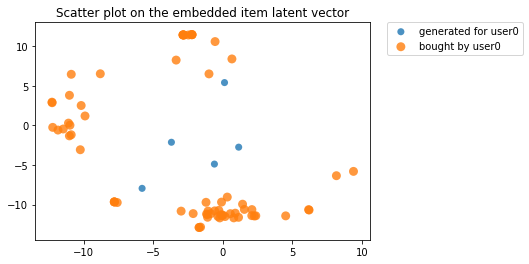

In [220]:
show_map(0)

Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


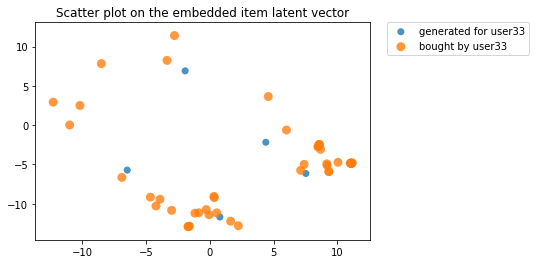

In [225]:
show_map(33)

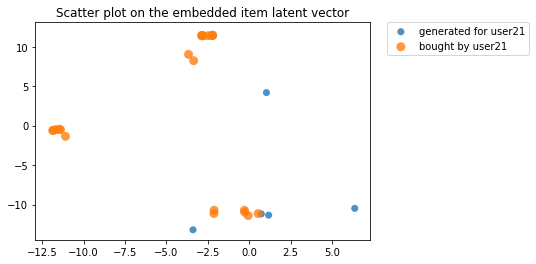

In [224]:
show_map(21)

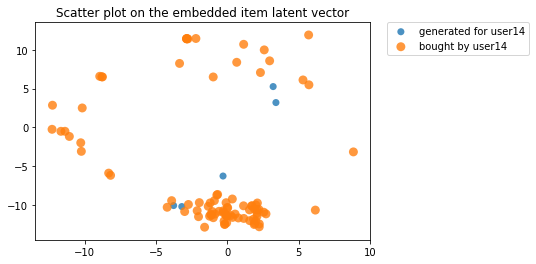

In [227]:
show_map(14)

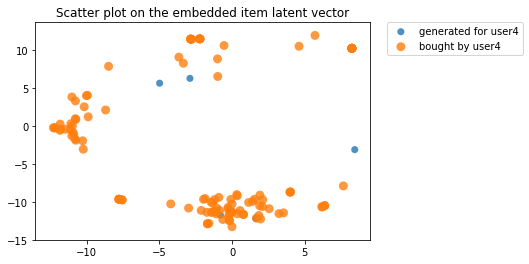

In [222]:
show_map(4)

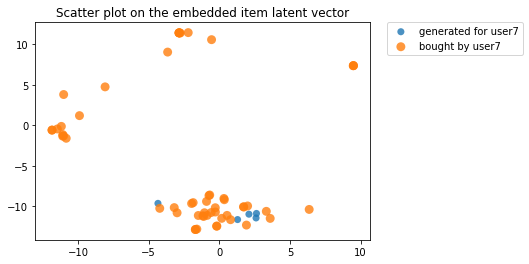

In [223]:
show_map(7)

In [87]:
# print len(generate_items_embedded) ,len(buy_items_embedded)
# colors = [0] * len(generate_items_embedded) + [1] * len(buy_items_embedded)
# print len(colors)
# mat = generate_items_embedded +  buy_items_embedded
# mat = np.array(mat)
# print np.shape(mat), np.shape(colors)

5 69
74
(74, 2) (74,)


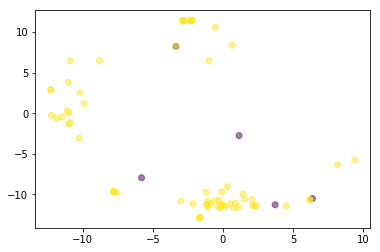

In [88]:
import matplotlib.pyplot as plt
plt.scatter(mat[:,0], mat[:,1], c=colors, alpha=0.5)
plt.show()